In [11]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from helpers_for_plotting import diff_post, dechunk_var, read_matrices

s = 2 # index of the simulation we want to have a closer look on
tw_s = [10, 10, 100, 100] # time window lengths in the simulated data


tw = int(tw_s[s]) 


#----------------------------------------------------------------------------------
# Read data from different simulations into list according to invm & useKG settings
#----------------------------------------------------------------------------------

npinv = [] # list for outputs with settings. invm = numpy.linalg.inv, useKG = True
bldiag = [] # 




#loop through simulations, read all but matrices from the data
for i in range(4):
    npinv.append(xr.open_mfdataset(f"simulated_data/with_real_prior_cov/simulation_{i:02d}/out_default_with_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    bldiag.append(xr.open_mfdataset(f"simulated_data/with_real_prior_cov/simulation_{i:02d}/out_block_diag_inv_with_kf/*.nc",
                        concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    
# data in the chosen simulation
data1 = npinv[s]
data2 = bldiag[s]




In [12]:
print(data1)

<xarray.Dataset>
Dimensions:      (time: 500, time2: 5, nstate: 6858)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Dimensions without coordinates: time2, nstate
Data variables:
    prior        (time2, nstate) float64 dask.array<chunksize=(1, 6858), meta=np.ndarray>
    posterior    (time2, nstate) float64 dask.array<chunksize=(1, 6858), meta=np.ndarray>
    obs          (time2, time) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    differences  (time2, time) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
Attributes:
    comments:  Matrix inverse function: inv from module: numpy.linalg. useKG:...


Read matrices
-------------------

In [ ]:

#------------------------------------------------------------------------------
# Had to read matrices in another way, as open_mfdataset didn't work with them
#----------------------------------------------------------------------------

Bs, As, Rs = read_matrices(s, 'out_default_with_kf')
#B_bl, A_bl, R_bl = read_matrices(s, "out_block_with_kf")

for i in range(6,9):
    print(np_t[i])

In [3]:
#init data

init = xr.open_dataset(f"simulated_data/with_real_prior_cov/simulation_{s:02d}/s{s:02d}_init.nc")
print(init.comments)
print(init.state.values)

prior cov: regions_verify_isotope_202112_cov.nc, bio, nstate: None, nobs: 50, tw: 10, x_mu: 1, y_mu: 1800, x_std: None, y_std: 15
[  8.44191455  -1.82355575   6.7113444   14.4899975    4.95016817
  -3.33908773   4.21070553   6.5013318   -6.58656739  -4.62516199
   4.14467968  -0.53113883  10.02929954  -2.11036446   5.66000541
 -11.99440513   0.7811387    5.65353219   7.55357082  -2.0162105
   2.78131962  -9.11320039  23.82452924   1.44642471  -5.25892539
   1.52354718  14.13316486  -0.53036537   4.13588423]


State vector - prior & posterior
--------------------------------

Changes so small that if I try to plot all nstates in the same plot, changes won't show, because plot will be too much zoomed out.
Better to plot one at a time as an example / sanity check

[3794 1670  961  902  939 1880 2148 3671 3182]


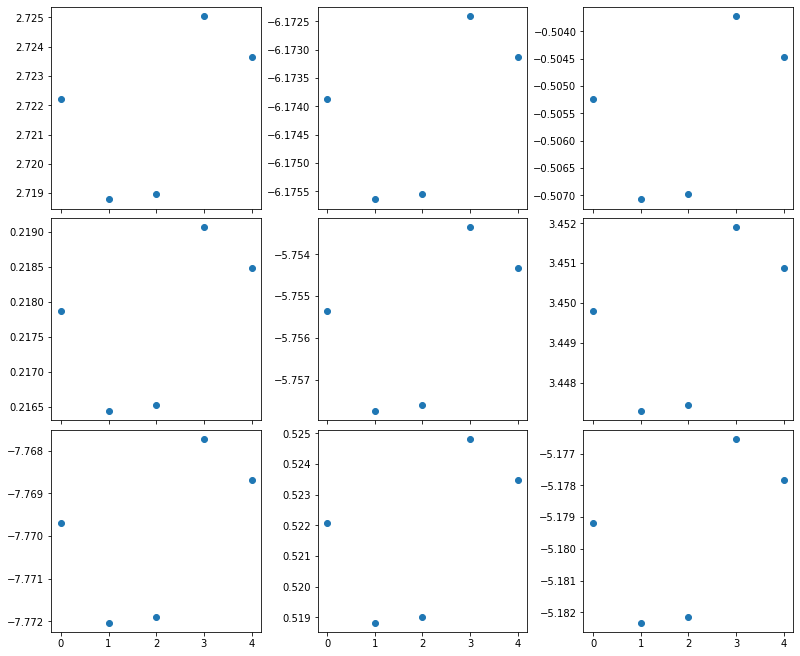

In [8]:
# Plots for several different states

nstate = data1.dims['nstate']
post = data1.posterior

states = np.random.randint(nstate, size = 9) #pick a couple of random states to look at
print(states)
selection = []
for i in range(9):
    selection.append(post.isel(nstate = states[i]))




fig, axs = plt.subplots(3,3, figsize = (11,9), layout = 'constrained', sharex = 'col')
for k in range(9):
    i = k // 3
    j = k - 3*i
    axs[i,j].plot(selection[k], 'o') # marker = 'o', color = 'red', alpha = 0.7)
plt.show()


2662


Text(0.5, 0.98, 'Posterior and prior values of a state using different inversion method')

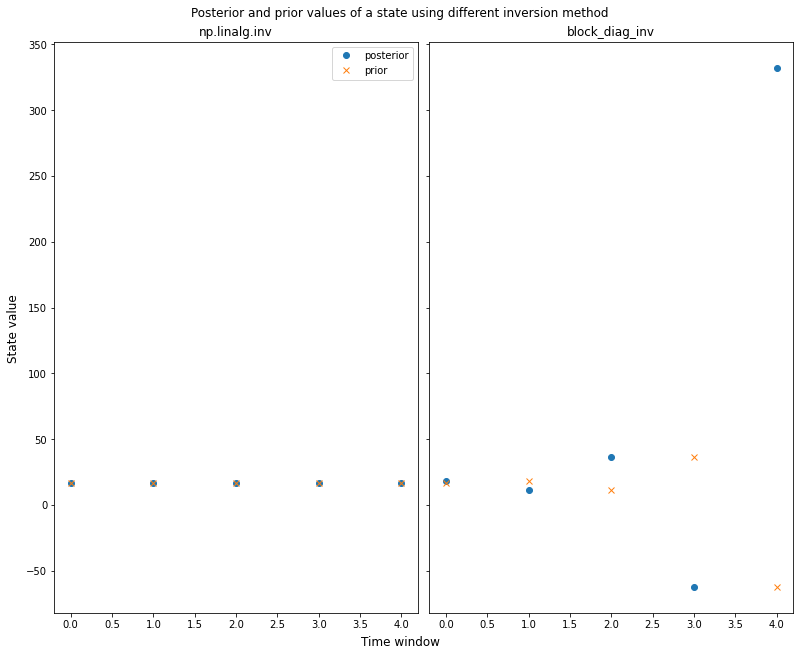

In [40]:
# Plots for one state prior & post in different datasets


stateno = np.random.randint(6858)
print(stateno)





fig, axs = plt.subplots(1,2, layout = 'constrained', sharey ='row', 
                        figsize = (11,9))

axs[0].plot(data1.posterior[:,stateno], 'o', label = "posterior")
axs[0].plot(data1.prior[:,stateno], 'x', label = "prior")
axs[1].plot(data2.posterior[:,stateno], 'o', label = "posterior")
axs[1].plot(data2.prior[:,stateno], 'x', label = "prior")

axs[0].set_title(f"np.linalg.inv")
axs[1].set_title(f"block_diag_inv")
axs[0].legend()
fig.supxlabel("Time window")
fig.supylabel("State value")
fig.suptitle(f'Posterior and prior values of a state using different inversion method')


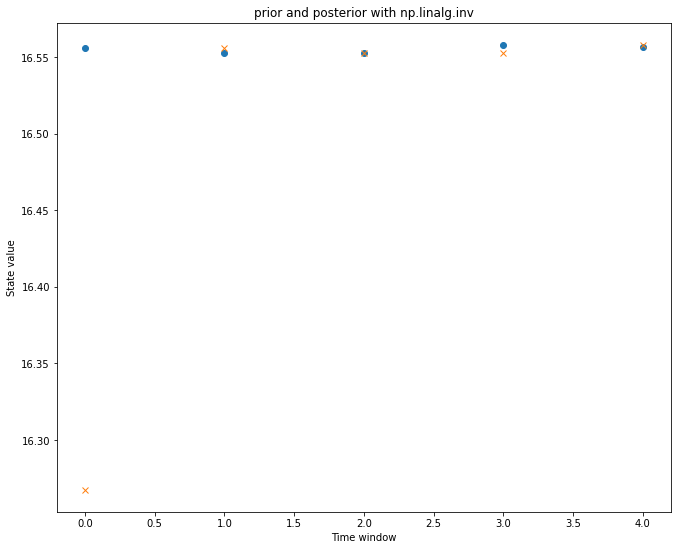

In [41]:
fig, ax = plt.subplots(figsize = (11,9))
ax.plot(data1.posterior[:,stateno], 'o')
ax.plot(data1.prior[:,stateno], 'x')
ax.set_xlabel("Time window")
ax.set_ylabel("State value")
ax.set_title("prior and posterior with np.linalg.inv")

plt.show()

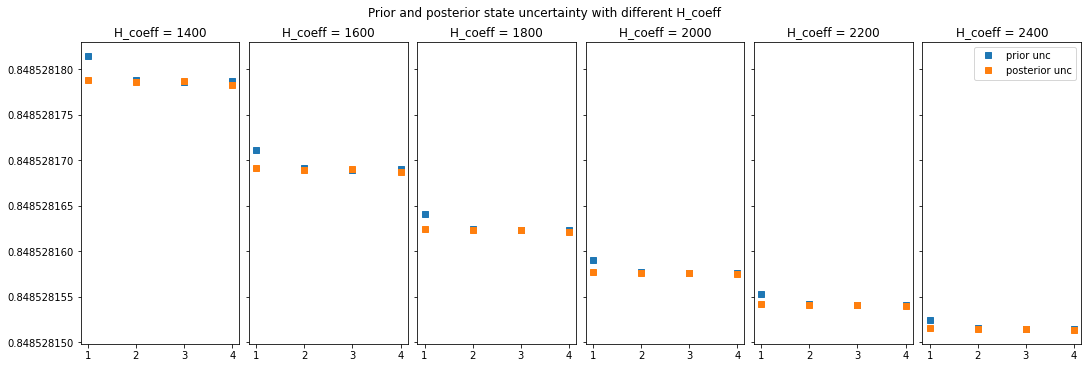

In [13]:
from math import sqrt

a_stds = {}
b_stds = {}

for coeff in coeffs:
    name = f"H_{coeff}"
    Bs, As, Rs = read_matrices(s, name)
    A_unc =[sqrt(A.values[stateno,stateno]) for A in As]
    B_unc = [sqrt(B.values[stateno,stateno]) for B in Bs]
    a_stds[name] = A_unc
    b_stds[name] = B_unc

fig, axs = plt.subplots(1,6, sharex = 'col', sharey = 'row', figsize = (15, 5), layout = 'constrained')

for k in range(6):
    i = k // 3
    j = k - 3*i
    coeff = coeffs[k]
    name = f"H_{coeff}"
    a = a_stds[name]
    b = b_stds[name]
    axs[k].plot(b[1:], 's', label = "prior unc")
    axs[k].plot(a[1:], 's', label = "posterior unc")
    axs[k].set_xticks(range(0,4), labels = range(1,5))
    axs[k].set_title(f"H_coeff = {coeff}")
    plt.gca().ticklabel_format(axis='y', useOffset = False)
axs[5].legend()
fig.suptitle("Prior and posterior state uncertainty with different H_coeff")
plt.show()



Observations
--------------

Text(0.5, 1.0, 'Observations (s02)')

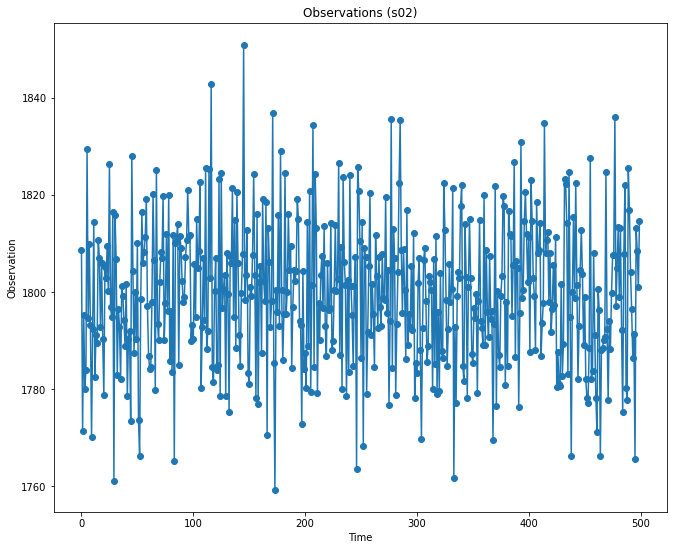

In [20]:

dat = data2


obs = dechunk_var(dat, 'obs', tw=tw) 

fig, ax = plt.subplots(figsize = (11,9))
ax.plot(obs, marker= 'o')
ax.set_xlabel('Time')
ax.set_ylabel('Observation')
ax.set_title(f'Observations (s0{s})')

Text(0.5, 1.0, 'Observations with alternating y_std')

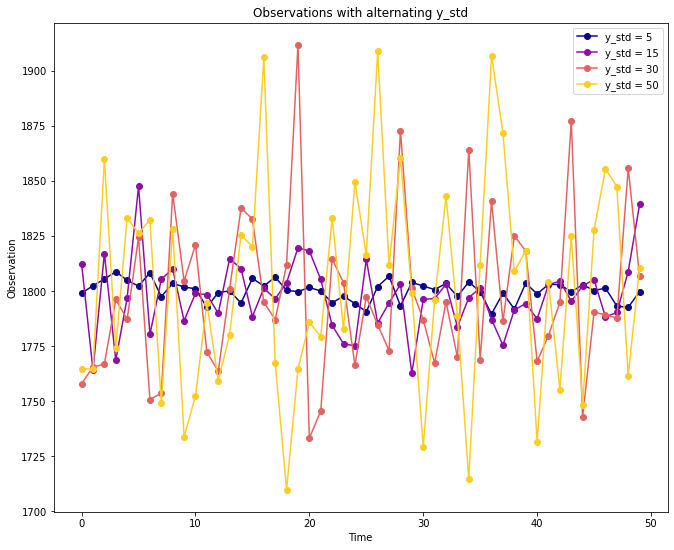

In [15]:
obss = {}
sims = [9,10,11,12]
y_stds = [5, 15, 30, 50]
# create colormap
cm = plt.cm.plasma(np.linspace(0, 0.9, 4))


fig, ax = plt.subplots(figsize = (11,9))
ax.set_prop_cycle('color', list(cm))
for i in range(4):
    sim = sims[i]
    y_std = y_stds[i]
    obss[f"obs{sim}"] = dechunk_var(np_t[sim], "obs", tw_s[sim]) 
    ax.plot(obss[f"obs{sim}"], label = f"y_std = {y_std}", marker  = 'o')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Observation')
ax.set_title(f'Observations with alternating y_std')


Obs - prior differences
-----------------------


In [ ]:
fig, ax = plt.subplots(figsize = (11,9))
da1 = dechunk_var(data1, "differences", tw=100)
da2 = dechunk_var(data2, "differences", tw=100)



Text(0.5, 1.0, 'Obs - prior differences with different coefficients for H')

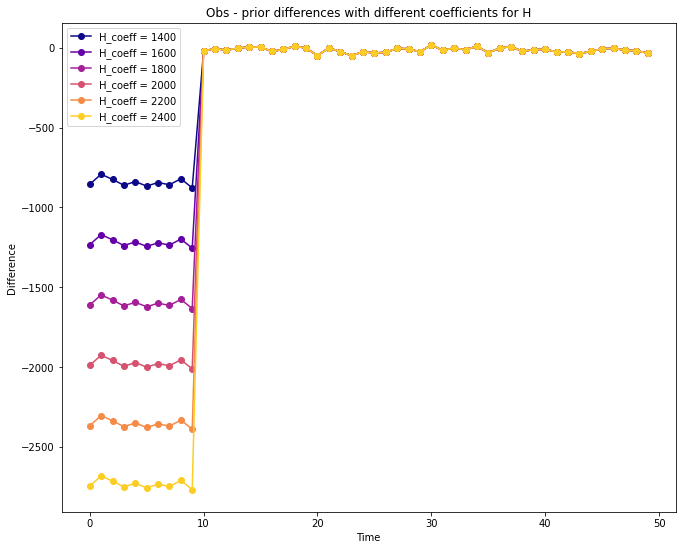

In [16]:


diff = {}
coeffs = range(1400, 2600, 200)

# create colormap
cm = plt.cm.plasma(np.linspace(0, 0.9, 6))


fig, ax = plt.subplots(figsize = (11,9))
ax.set_prop_cycle('color', list(cm))
for i in range(6):
    da = dataH[i]
    H_coeff = coeffs[i]
    diff[f"diff{i}"] = dechunk_var(da, "differences", tw=10) 
    ax.plot(diff[f"diff{i}"], label = f"H_coeff = {H_coeff}", marker  = 'o')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Difference')
ax.set_title(f'Obs - prior differences with different coefficients for H')

Text(0.5, 1.0, 'Obs - prior differences with different coefficients for H')

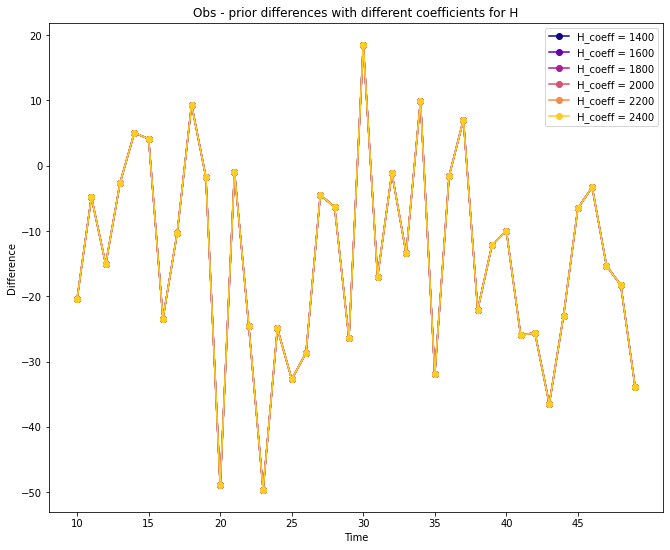

In [15]:
# Same but only tws 10-50

fig, ax = plt.subplots(figsize = (11,9))
ax.set_prop_cycle('color', list(cm))
for i in range(6):
    da = dataH[i]
    H_coeff = coeffs[i]
    diff[f"diff{i}"] = dechunk_var(da, "differences", tw=10) 
    ax.plot(diff[f"diff{i}"].sel(time = slice(10,50)), label = f"H_coeff = {H_coeff}", marker  = 'o')
ax.legend()
ax.set_xticks(range(0,40,5), labels = range(10,50,5))
ax.set_xlabel('Time')
ax.set_ylabel('Difference')
ax.set_title(f'Obs - prior differences with different coefficients for H')

Text(0.5, 1.0, 'Obs - posterior differences with different coefficients for H')

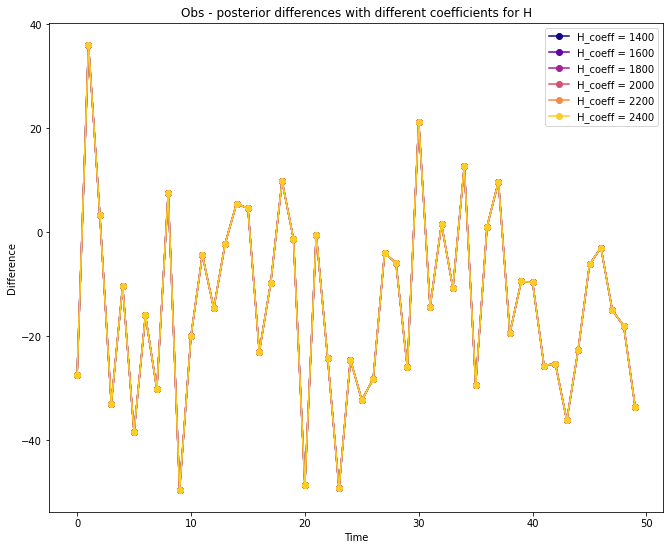

In [17]:


diff_po = {}

# create colormap
cm = plt.cm.plasma(np.linspace(0, 0.9, 6))


fig, ax = plt.subplots(figsize = (11,9))
ax.set_prop_cycle('color', list(cm))
for i in range(6):
    da = dataH[i]
    H_coeff = coeffs[i]
    diff_po[f"diff_po{i}"] = diff_post(da, H_coeff)
    ax.plot(diff_po[f"diff_po{i}"], label = f"H_coeff = {H_coeff}", marker  = 'o')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Difference')
ax.set_title(f'Obs - posterior differences with different coefficients for H')

Obs - posterior differences
-----------------------------

In [50]:


from helpers_for_plotting import diff_post

diff_po = diff_post(np_t[s])
diff_pr = dechunk_var(np_t[s], "differences", tw) 

fig, ax = plt.subplots(figsize = (11,9))
ax.plot(diff_po, marker = 'o', color = 'blue', alpha = 0.8, label = "Obs - posterior")
ax.plot(diff_pr, marker = 'x', color = 'red', linestyle = 'dashed', alpha = 0.8, label = "Obs - prior")
ax.set_xlabel("Time")
ax.set_ylabel("Difference")
ax.legend()
ax.set_title(f"Obs - posterior vs. obs - prior differences (s0{s}, np.linalg.inv, useKG = True)")
plt.show()

IndexError: list index out of range

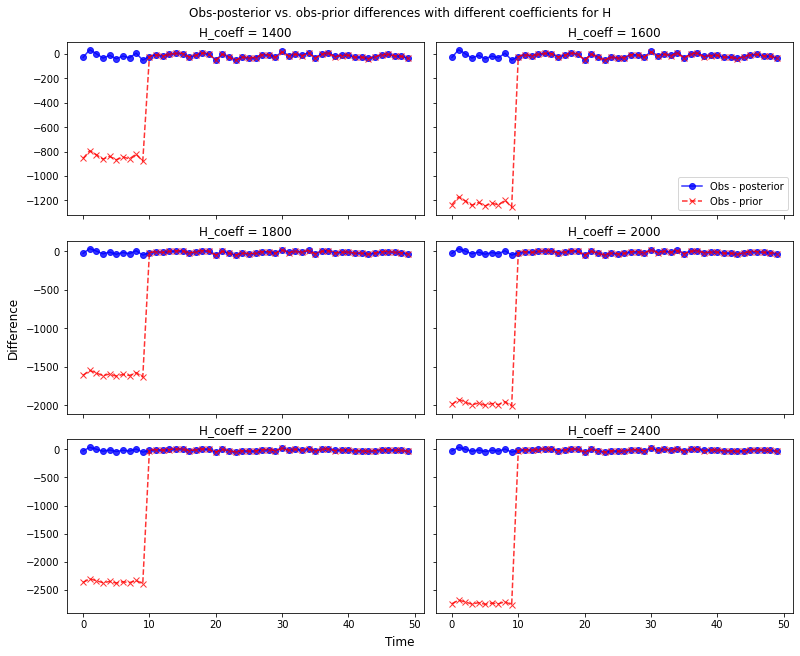

In [18]:




fig, axs = plt.subplots(3,2, figsize = (11,9), layout = 'constrained', sharex = 'col', sharey = 'row')
for k in range(6):
    i = k // 2
    j = k-2*i
    da = dataH[k]
    H_coeff = coeffs[k]
    diff_po = diff_post(da, H_coeff)
    diff_pr = dechunk_var(da, "differences", tw = 10)
    axs[i,j].plot(diff_po, marker = 'o', color = 'blue', alpha = 0.8, label = "Obs - posterior")
    axs[i,j].plot(diff_pr, marker = 'x', color = 'red', linestyle = 'dashed', alpha = 0.8, label = "Obs - prior")
    axs[i,j].set_title(f"H_coeff = {H_coeff}")
axs[0,1].legend()
fig.supxlabel('Time')
fig.supylabel('Difference')
fig.suptitle('Obs-posterior vs. obs-prior differences with different coefficients for H')
plt.show()
 





Same, but leave out first time window

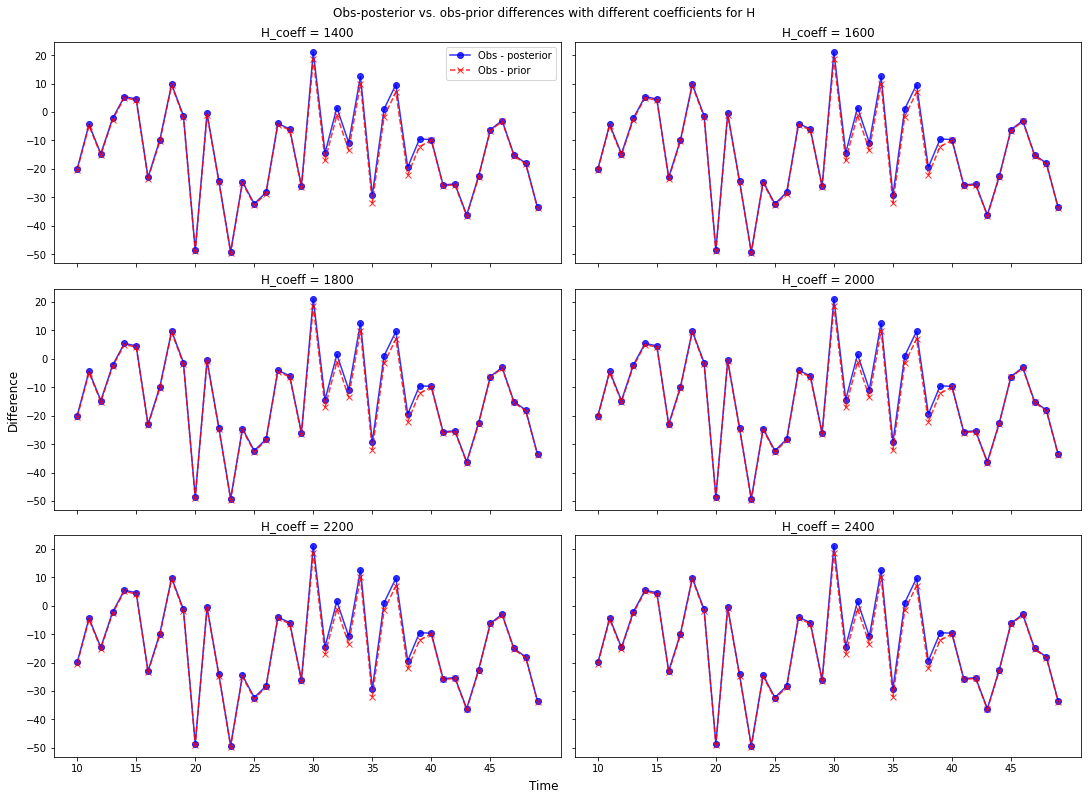

In [20]:
fig, axs = plt.subplots(3,2, figsize = (15,11), layout = 'constrained', sharex = 'col', sharey = 'row')
for k in range(6):
    i = k // 2
    j = k-2*i
    da = dataH[k]
    H_coeff = coeffs[k]
    diff_po = diff_post(da, H_coeff)
    diff_pr = dechunk_var(da, "differences", tw = 10)
    axs[i,j].plot(diff_po.sel(time = slice(10,50)), marker = 'o', color = 'blue', alpha = 0.8, label = "Obs - posterior")
    axs[i,j].plot(diff_pr.sel(time = slice(10,50)), marker = 'x', color = 'red', linestyle = 'dashed', alpha = 0.8, label = "Obs - prior")
    axs[i,j].set_title(f"H_coeff = {H_coeff}")
    axs[i,j].set_xticks(range(0,40,5), labels = range(10,50,5))
axs[0,0].legend()
fig.supxlabel('Time')
fig.supylabel('Difference')
fig.suptitle('Obs-posterior vs. obs-prior differences with different coefficients for H')
plt.show()

In [8]:
dat = diff_post(dataH[0], coeffs[0])
datslice = dat.sel(time = slice(10,50))
datslice

<xarray.DataArray 'obs' (time: 40)>
dask.array<getitem, shape=(40,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 10 11 12 13 14 15 16 17 18 ... 42 43 44 45 46 47 48 49

Covariance and observation uncertainty matrices
------------------------------------------------

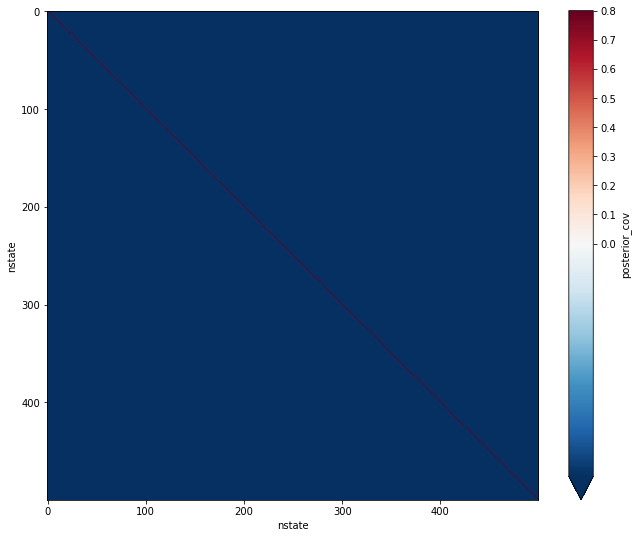

In [56]:
M = A[4]

qlower = np.quantile(M, 0.01)
qupper = np.quantile(M, 0.99)

fig, ax = plt.subplots(figsize = (11,9))
norm = colors.TwoSlopeNorm(vmin = min(0,qlower), vcenter = 0, vmax = max(0.8,qupper))
M.plot.imshow(ax=ax, yincrease = False, norm = norm)
plt.show()


Multiple subplots in same figure

* turns out the colorbar normalation is tricky


The easiest but ugliest way out: each subplot has its own colorbar, and colorbar ranges differ.


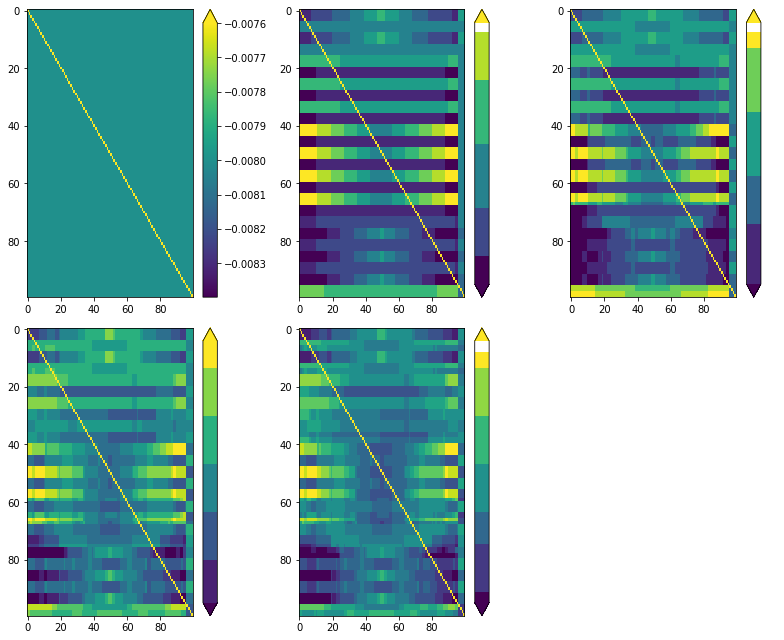

In [ ]:

fig, axs = plt.subplots(2,3, figsize = (11,9))
axs[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    A_np[k].plot.imshow(ax = axs[i,j], yincrease = False, add_labels = False, robust = True)
plt.tight_layout()
plt.show()



QUANTILES + SYMLOGNORM

Problem with SymLogNorm: plots a really nice plot but the colormap doesn't center at zero

Colorbar min and max set manually to certain quantiles.
Alfa has to be really small < 10**(-3) 
Otherwise all but the first subplot seem to become uniformly one color
because such an immense part of the values within very small range around zero


-0.001599907412765469 0.7984004628290428


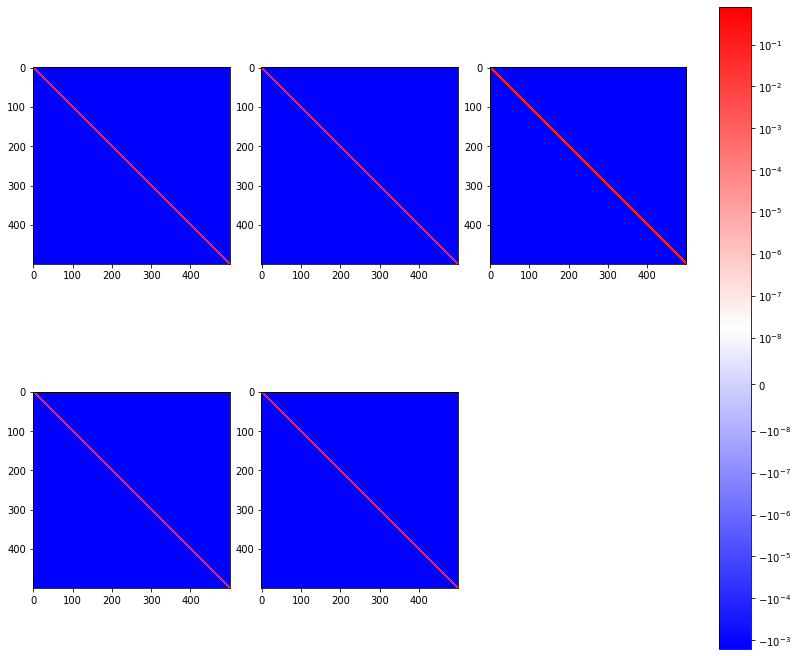

In [8]:

qlower = min(np.quantile(A.values, 0.001) for A in As)
qupper = max(np.quantile(A.values, 0.999) for A in As)
vmin = min(A.values.min() for A in As)
vmax = max(A.values.max() for A in As)
print(qlower, qupper)

fig, axs = plt.subplots(2,3, figsize = (11,9), layout = 'constrained')
axs[-1,-1].axis('off')

images = []
for k in range(5):
    i = k // 3
    j = k - 3*i
    images.append(axs[i,j].imshow(As[k], cmap = 'bwr'))
    #axs[i, j].label_outer()

#norm = colors.TwoSlopeNorm(vcenter = 0.0, vmin = qlower, vmax = qupper)

from normalize_midpoint import MidpointNormalize
#norm = MidpointNormalize(vmin=qlower, vmax=qupper, midpoint=0)
norm = colors.SymLogNorm(vmin=qlower, vmax = qupper, linthresh = 10**(-8))
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm)
plt.show()



From stackexchange: 

This is for the more complex case where the values are not just between 0 and 1; the cmap needs to be shared instead of just using the last one.


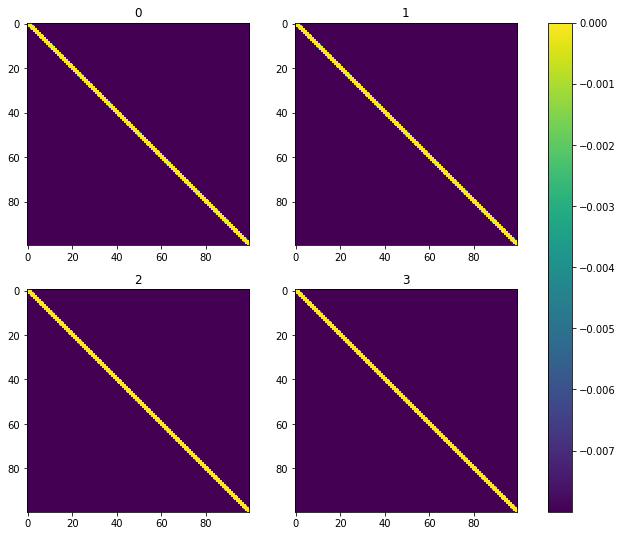

In [ ]:



import matplotlib.cm as cm
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (11, 9))
cmap=cm.get_cmap('viridis')
normalizer=colors.Normalize(qlower, qupper)
im=cm.ScalarMappable(norm=normalizer, cmap = cmap)
for i,ax in enumerate(axes.flat):
    ax.imshow(A_np[i],cmap=cmap,norm=normalizer)
    ax.set_title(str(i))
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

Another one from stackexchange

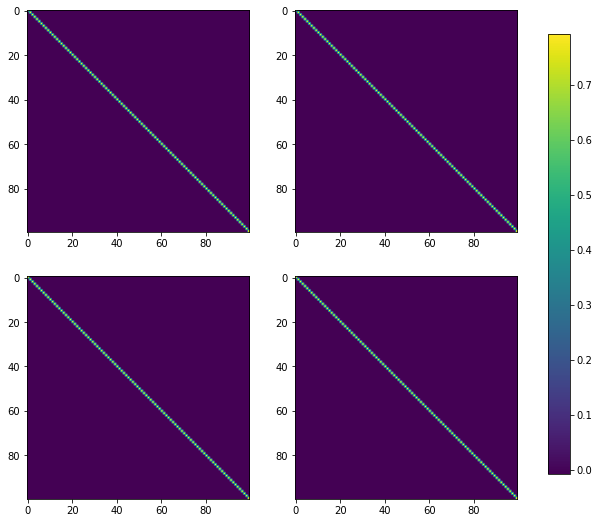

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (11,9))
i = 1
for ax in axs.flat:
    plt.sca(ax)
    plt.imshow(A_np[i], cmap='viridis')
    i += 1
plt.colorbar(ax=axs.ravel().tolist(), shrink=0.9)
plt.show()




How about matshow?



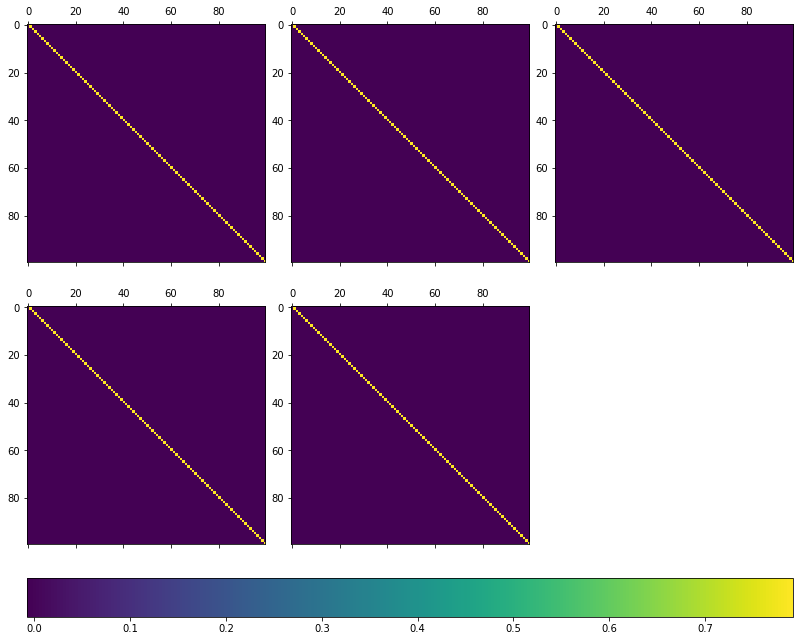

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (11,9), layout = 'constrained')
axes[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    im = axes[i,j].matshow(A_np[k])

fig.colorbar(im, ax=axes.ravel().tolist(), norm = colors.Normalize(vmin = vmin, vmax = vmax), location = 'bottom')

plt.show()

In [ ]:
data = xr.open_dataset()